# CO460 - Deep Learning - Tutorial 5

## Introduction

In this tutorial, there are two parts:

First we demonstrate:
- A Generative Adversarial Network (GAN) 
- A Conditional Generative Adversarial Network (cGAN)

Second:
- Exercise and experimentations with GAN architectures and sampling

In [0]:
from google.colab import files
from IPython.display import Image

In [0]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# utils
def interpolate(z1, z2, num=11):
    Z = np.zeros((z1.shape[0], num))
    for i in range(z1.shape[0]):
        Z[i, :] = np.linspace(z1[i], z2[i], num)
    return Z

def denorm_for_tanh(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x

def denorm_for_sigmoid(x):
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x

def denorm_for_binary(x):
    x = x.clamp(0, 1)
    x = x>0.5
    x = x.view(x.size(0), 1, 28, 28)
    return x

def show(img):
    if torch.cuda.is_available():
        img = img.cpu()
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

### Device selection

In [0]:
GPU = True
device_idx = 0
if GPU:
    device = torch.device("cuda:" + str(device_idx) if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
print(device)

cuda:0


### Reproducibility

In [0]:
# We set a random seed to ensure that your results are reproducible.
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
torch.manual_seed(0)

###  Normalization: 

$ x_{norm} = \frac{x-\mu}{\sigma} $

* Same as in the previous tutorial: input after normalization $\in [-1,1] $
* Activation function of the Generator output layer should be tanh

In [0]:
transform = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize(mean=(0.5,), std=(0.5,))
])

train_dat = datasets.MNIST(
    "data/", train=True, download=True, transform=transform
)
test_dat = datasets.MNIST("./data/", train=False, transform=transform)

denorm = denorm_for_tanh

if not os.path.exists('./cGAN'):
    os.mkdir('./cGAN')
    
if not os.path.exists('./GAN'):
    os.mkdir('./GAN')

Processing...
Done!


### Hyper-parameter selection

In [0]:
num_epochs = 100
batch_size = 128
learning_rate = 2e-4
noise_dim = 128
h_dim1 = 256
h_dim2 = 512
h_dim3 = 1024
in_dim = np.prod(train_dat[0][0].shape)
out_shape = train_dat[0][0].shape

sample_interval = 5

In [0]:
train_loader = DataLoader(train_dat, batch_size, shuffle=True, num_workers=16)
test_loader = DataLoader(test_dat, batch_size, shuffle=False, num_workers=16)


## Part I - Generative Adversarial Network

### Reminder:

**Zero-Sum game objective**:

$$\min_{\theta_G}\max_{\theta_D} \mathbb{E}_{x\sim p_{data}}[\log D(x)] + \mathbb{E}_{z\sim p_z}[\log (1- D(G(z)))] 
\\= \min_{\theta_G}\max_{\theta_D} \sum_{x,z} y_x \log D(x) +(1-y_{G(z)})\log (1-D(G(z))) : Binary Cross Entropy
$$

where $y_x = 1, y_{G(z)} = 0 $


**Baseline Algorithm**:

- For N epochs repeat:
    1. Sample N samples $x\sim p_{data}$ and N samples $z\sim p_{z}$
    2. Predict the labels that the Discriminator assigns.  Then backpropagate the error across the Discriminator $\to$ gradient ascent for the Discriminator.
    3. Predict the new labels that the Discriminator assigns to fake examples. Then backpropagate the error across the Generator $\to$ gradient descent for the Generator.
   
**Alternatively**:

- Sample some real data and some fake ones.
- Train the Discriminator for a few steps.
- Sample some fake data
- Then train the Generator for one step.

**Note**:

- Usually for the Generator, instead of the original function we minimize: $\min_{\theta_G} - \mathbb{E}_{z\sim p_z}[\log D(G(z))] $

https://arxiv.org/pdf/1406.2661.pdf


### Define the model - GAN structure

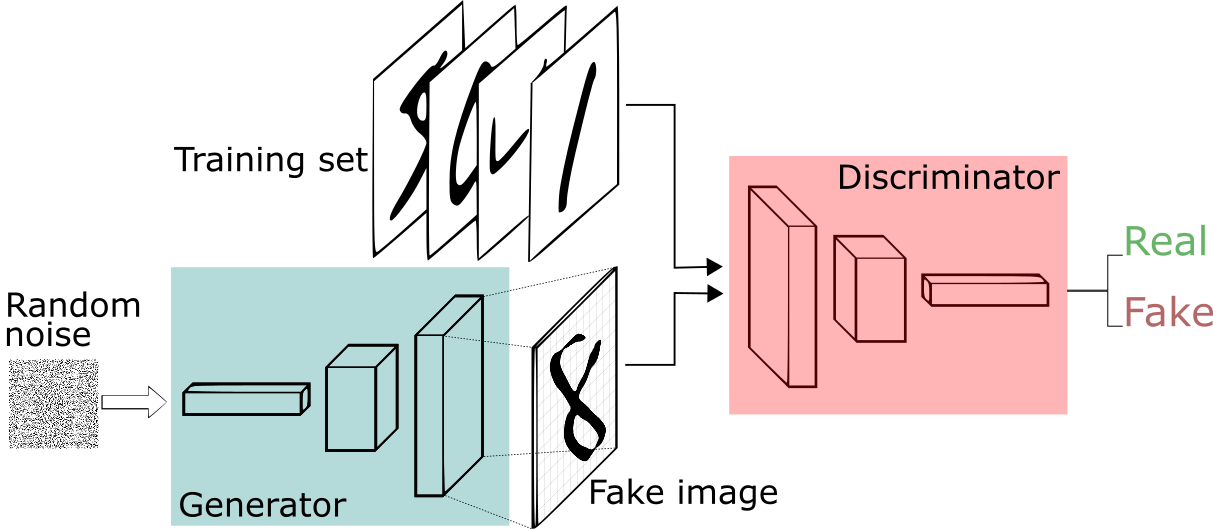

In [0]:
Image('GAN.png', width=800)

In [0]:
class Generator(torch.nn.Module):

    def __init__(self, in_dim = 128, h_dim1 = 256, \
                                            h_dim2 = 512, h_dim3 = 1024, out_shape = out_shape):
        super(Generator, self).__init__()
        
        self.out_shape = out_shape
        
        self.hidden0 = nn.Sequential(
            nn.Linear(in_dim, h_dim1),
            nn.ReLU()
        )
        self.hidden1 = nn.Sequential(            
            nn.Linear(h_dim1,h_dim2),
            nn.ReLU()
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(h_dim2, h_dim3),
            nn.ReLU()
        )
        
        self.out = nn.Sequential(
            nn.Linear(h_dim3, np.prod(out_shape)),
            nn.Tanh()
        )
        

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        x = x.view(x.size(0),*self.out_shape)
        return x
    
    
    
    
    
class Discriminator(torch.nn.Module):

    def __init__(self, in_dim = 784, h_dim1 = 1024, \
                                               h_dim2 = 512, h_dim3 = 256, out_dim = 1):
        super(Discriminator, self).__init__()
        
        self.hidden0 = nn.Sequential( 
            nn.Linear(in_dim, h_dim1),
            nn.ReLU()

        )
        self.hidden1 = nn.Sequential(
            nn.Linear(h_dim1, h_dim2),
            nn.ReLU()

        )
        self.hidden2 = nn.Sequential(
            nn.Linear(h_dim2, h_dim3),
            nn.ReLU()

        )
        self.out = nn.Sequential(
            torch.nn.Linear(h_dim3, out_dim),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x


In [0]:
generator = Generator(in_dim = noise_dim, h_dim1= h_dim1, \
                              h_dim2=h_dim2, h_dim3 = h_dim3, out_shape = out_shape)
discriminator = Discriminator(in_dim = in_dim, h_dim1= h_dim3, \
                              h_dim2=h_dim2, h_dim3 = h_dim1, out_dim = 1)


### Define Loss function

In [0]:
criterion = nn.BCELoss(reduction='mean')
def loss_function(out, label):
    loss = criterion(out, label)
    return loss

### Initialize Model and print number of parameters

In [0]:
generator = generator.to(device)
discriminator = discriminator.to(device)

params = sum(p.numel() for p in generator.parameters() if p.requires_grad)
print("Total number of generator parameters is: {}".format(params))  # what would the number actually be
print(generator)

params = sum(p.numel() for p in discriminator.parameters() if p.requires_grad)
print("Total number of discriminator parameters is: {}".format(params))  # what would the number actually be
print(discriminator)

Total number of generator parameters is: 1493520
Generator(
  (hidden0): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): ReLU()
  )
  (hidden1): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): ReLU()
  )
  (hidden2): Sequential(
    (0): Linear(in_features=512, out_features=1024, bias=True)
    (1): ReLU()
  )
  (out): Sequential(
    (0): Linear(in_features=1024, out_features=784, bias=True)
    (1): Tanh()
  )
)
Total number of discriminator parameters is: 1460225
Discriminator(
  (hidden0): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): ReLU()
  )
  (hidden1): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): ReLU()
  )
  (hidden2): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): ReLU()
  )
  (out): Sequential(
    (0): Linear(in_features=256, out_features=1, bias=True)
    (1): Sigmoid()
  )
)


### Choose and initialize optimizer

In [0]:
optimizer_G = torch.optim.Adam(generator.parameters(), lr=learning_rate)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=learning_rate)

### Pick a noise distribution

In [0]:
def generate_noise(batch_size, noise_dim):
    noise = torch.randn(batch_size, noise_dim)
    return noise                        

 ### Train

In [0]:
g_losses = []
d_losses = []
generator.train()
discriminator.train()
num_epochs = 100 

fixed_noise = generate_noise(batch_size, noise_dim)

for epoch in range(num_epochs):
    g_loss_epoch = 0
    d_loss_epoch = 0 
    for batch_idx, data in enumerate(train_loader):
        
        img, _ = data
        # 1) sample some real data, 2) assign a 1 as ground truth
        img = img.to(device)
        valid = torch.ones(img.size(0), 1, requires_grad=False).to(device)
        
        # 1)Sample noise as generator input, 2) generate a batch of images, 3) assing a 0 as ground truth
        z = generate_noise(img.size(0), noise_dim).to(device)
        gen_imgs = generator(z)
        fake = torch.zeros(img.size(0), 1, requires_grad=False).to(device)
        
        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = loss_function (discriminator(img), valid)
        fake_loss = loss_function(discriminator(gen_imgs.detach()), fake)
        d_loss = real_loss + fake_loss

        d_loss.backward()
        d_loss_epoch += d_loss.item()
        optimizer_D.step()

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Loss measures generator's ability to fool the discriminator
        g_loss = loss_function(discriminator(gen_imgs), valid)

        g_loss.backward()
        g_loss_epoch += g_loss.item()
        optimizer_G.step()


    print('epoch [{}/{}], generator loss:{:.4f}'
          .format(epoch + 1, num_epochs, g_loss_epoch / len(train_loader)))
    g_losses.append(g_loss_epoch/ len(train_loader))
    print('epoch [{}/{}], discriminator loss:{:.4f}'
          .format(epoch + 1, num_epochs, d_loss_epoch / len(train_loader)))
    d_losses.append(d_loss_epoch/ len(train_loader))
    if epoch % sample_interval == 0:
        save_image(denorm(generator(fixed_noise.to(device))).cpu(), './GAN/samples_epoch_{}.png'.format(epoch),nrow = 8)
    torch.save(generator.state_dict(), './GAN/generator.pth')
    torch.save(discriminator.state_dict(), './GAN/discriminator.pth')
    
np.save('./GAN/generator_losses.npy', np.array(g_losses))
np.save('./GAN/discriminator_losses.npy', np.array(d_losses))

epoch [1/100], generator loss:7.1114
epoch [1/100], discriminator loss:0.2447
epoch [2/100], generator loss:13.1800
epoch [2/100], discriminator loss:0.1112
epoch [3/100], generator loss:6.1448
epoch [3/100], discriminator loss:0.3026
epoch [4/100], generator loss:6.6215
epoch [4/100], discriminator loss:0.1855
epoch [5/100], generator loss:6.2089
epoch [5/100], discriminator loss:0.1152
epoch [6/100], generator loss:8.0146
epoch [6/100], discriminator loss:0.1457
epoch [7/100], generator loss:7.8418
epoch [7/100], discriminator loss:0.1160
epoch [8/100], generator loss:8.4121
epoch [8/100], discriminator loss:0.1220
epoch [9/100], generator loss:7.8276
epoch [9/100], discriminator loss:0.1823
epoch [10/100], generator loss:7.6995
epoch [10/100], discriminator loss:0.1438
epoch [11/100], generator loss:6.8888
epoch [11/100], discriminator loss:0.1369
epoch [12/100], generator loss:6.6466
epoch [12/100], discriminator loss:0.1740
epoch [13/100], generator loss:6.5835
epoch [13/100], dis

### Loss curves

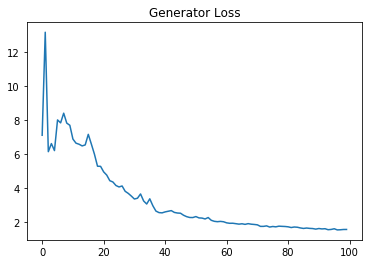

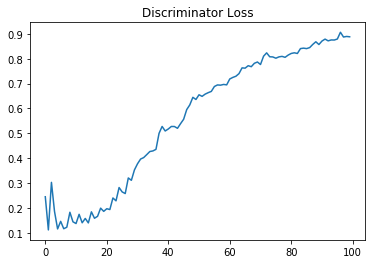

In [0]:
import matplotlib.pyplot as plt

generator_losses = np.load('./GAN/generator_losses.npy')
plt.plot(list(range(0,generator_losses.shape[0])), generator_losses)
plt.title('Generator Loss')
plt.show()

import matplotlib.pyplot as plt
discriminator_losses = np.load('./GAN/discriminator_losses.npy')
plt.plot(list(range(0,discriminator_losses.shape[0])), discriminator_losses)
plt.title('Discriminator Loss')
plt.show()

### Sampling

In [0]:
generator.load_state_dict(torch.load("./GAN/generator.pth"))

generator.eval()
n_samples = 32
with torch.no_grad():
    z = generate_noise(n_samples*n_samples, noise_dim).to(device)
    samples = generator(z)
    save_image(denorm(samples).type(torch.FloatTensor).cpu(), './GAN/samples' + '.png',nrow = n_samples)


## Conditional GAN

The concept of conditional GAN: 

* $\mathbf{x}$ refers to a train datum
* $\mathbf{y}$ refers to the corresponding label
* $\mathbf{z}$ refers to random noise vector

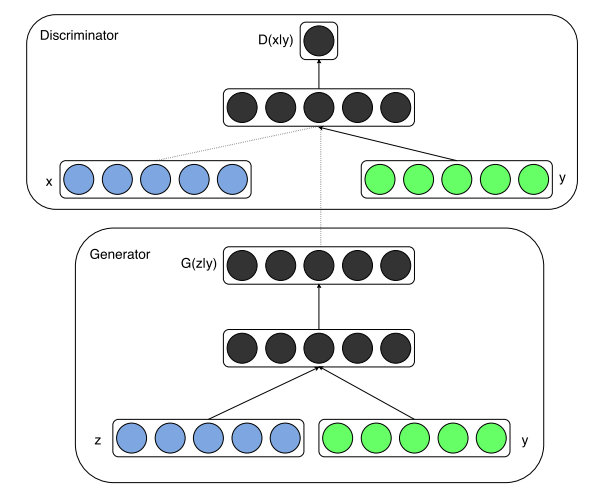

In [0]:
Image('cGAN.png', width=600)

### Hyper-parameter selection

In [0]:
num_epochs = 20
batch_size = 128

learning_rate = 0.0002
beta_1 = 0.5
beta_2 = 0.999

latent_dim = 128
num_classes = 10

num_workers = 16
sample_interval = 2

### Define the dataloaders

In [0]:
train_loader = DataLoader(train_dat, batch_size, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(test_dat, batch_size, shuffle=False, num_workers=num_workers)
total_step = len(train_loader)

it = iter(test_loader)
sample_inputs, _ = next(it)

in_dim = sample_inputs.shape[-1] * sample_inputs.shape[-2]

### Define the Generator (G)

In [0]:
class Generator(nn.Module):
    def __init__(self, latent_dim=128, image_size=784):
        super(Generator, self).__init__()
        self.fc1_1 = nn.Linear(latent_dim, 256)  # accounts for the noise z
        self.fc1_1_bn = nn.BatchNorm1d(256)
        self.fc1_2 = nn.Linear(10, 256)  # accounts for the labels
        self.fc1_2_bn = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(512, 512)
        self.fc2_bn = nn.BatchNorm1d(512)
        self.fc3 = nn.Linear(512, 1024)
        self.fc3_bn = nn.BatchNorm1d(1024)
        self.fc4 = nn.Linear(1024, image_size)

    def forward(self, noise, labels):
        x = F.relu(self.fc1_1_bn(self.fc1_1(noise)))
        y = F.relu(self.fc1_2_bn(self.fc1_2(labels)))
        x = torch.cat([x, y], 1)
        x = F.relu(self.fc2_bn(self.fc2(x)))
        x = F.relu(self.fc3_bn(self.fc3(x)))
        x = torch.tanh(self.fc4(x))

        return x

### Define the Discriminator (D)

In [0]:
class Discriminator(nn.Module):
    def __init__(self, image_size=784):
        super(Discriminator, self).__init__()
        self.fc1_1 = nn.Linear(image_size, 1024)
        self.fc1_2 = nn.Linear(10, 1024)
        self.fc2 = nn.Linear(2048, 512)
        self.fc2_bn = nn.BatchNorm1d(512)
        self.fc3 = nn.Linear(512, 256)
        self.fc3_bn = nn.BatchNorm1d(256)
        self.fc4 = nn.Linear(256, 1)

    def forward(self, images, labels):
        x = F.leaky_relu(self.fc1_1(images), 0.2)
        y = F.leaky_relu(self.fc1_2(labels), 0.2)
        x = torch.cat([x, y], 1)
        x = F.leaky_relu(self.fc2_bn(self.fc2(x)), 0.2)
        x = F.leaky_relu(self.fc3_bn(self.fc3(x)), 0.2)
        x = torch.sigmoid(self.fc4(x))

        return x

In [0]:
generator = Generator(latent_dim, in_dim)
discriminator = Discriminator(in_dim)

### Define loss function

In [0]:
criterion = nn.BCELoss(reduction='mean')
def loss_function(out, label):
    loss = criterion(out, label)
    return loss

### Initialize Model and print number of parameters for both G and D

In [0]:
generator = generator.to(device)
discriminator = discriminator.to(device)
g_params = sum(p.numel() for p in generator.parameters() if p.requires_grad)
d_params = sum(p.numel() for p in discriminator.parameters() if p.requires_grad)
print("The number of parameters for G is: {}".format(g_params))
print("The number of parameters for D is: {}".format(d_params))
print("The total number of parameters is: {}".format(g_params + d_params))

The number of parameters for G is: 1631504
The number of parameters for D is: 1997313
The total number of parameters is: 3628817


### Choose and initialize optimizer

In [0]:
g_optimizer = torch.optim.Adam(generator.parameters(), lr=learning_rate, betas=(beta_1, beta_2))
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(beta_1, beta_2))

### Train

In [0]:
generator.train()
discriminator.train()
g_losses = []
d_losses = []

fixed_noise = torch.rand(num_classes, latent_dim).to(device)
fixed_labels = np.arange(num_classes)
fixed_labels = (torch.from_numpy(fixed_labels)).type(torch.LongTensor)
fixed_labels = fixed_labels.to(device)
fixed_labels_one_hot = torch.zeros(num_classes, num_classes).to(device)
fixed_labels_one_hot.scatter_(1, fixed_labels.view(num_classes, 1), 1)

for epoch in range(num_epochs):
    g_loss_epoch = 0
    d_loss_epoch = 0
    
    for batch_idx, (images, labels) in enumerate(train_loader):
        batch_size = images.size(0)

        # train Discriminator
        images = images.view(batch_size, -1).to(device)

        real_labels = torch.ones(batch_size).to(device)
        fake_labels = torch.zeros(batch_size).to(device)

        labels_one_hot = torch.zeros(batch_size, 10)
        labels_one_hot.scatter_(1, labels.view(batch_size, 1).type(torch.LongTensor), 1)
        labels_one_hot = labels_one_hot.to(device)

        outputs = discriminator(images, labels_one_hot).squeeze()
        d_loss_real = loss_function(outputs, real_labels)

        z = torch.rand(batch_size, latent_dim).to(device)
        z_labels = (torch.rand(batch_size, 1)*num_classes).type(torch.LongTensor)  # ten classes for MNIST
        z_labels = z_labels.to(device)
        z_labels_one_hot = torch.zeros(batch_size, 10).to(device)
        z_labels_one_hot.scatter_(1, z_labels.view(batch_size, 1), 1)

        fake_images = generator(z, z_labels_one_hot)
        outputs = discriminator(fake_images, z_labels_one_hot).squeeze()
        d_loss_fake = loss_function(outputs, fake_labels)

        d_loss = d_loss_real + d_loss_fake
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        
        d_loss_epoch += d_loss.item()

        # train Generator

        z = torch.rand(batch_size, latent_dim).to(device)
        z_labels = (torch.rand(batch_size, 1)*10).type(torch.LongTensor)  # ten classes for MNIST
        z_labels = z_labels.to(device)
        z_labels_one_hot = torch.zeros(batch_size, 10).to(device)
        z_labels_one_hot.scatter_(1, z_labels.view(batch_size, 1), 1)

        fake_images = generator(z, z_labels_one_hot)
        outputs = discriminator(fake_images, z_labels_one_hot).squeeze()

        g_loss = criterion(outputs, real_labels)
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        
        g_loss_epoch += g_loss.item()
        
    print('epoch [{}/{}], generator loss:{:.4f}'
          .format(epoch + 1, num_epochs, g_loss_epoch / len(train_loader)))
    g_losses.append(g_loss_epoch/ len(train_loader))
    print('epoch [{}/{}], discriminator loss:{:.4f}'
          .format(epoch + 1, num_epochs, d_loss_epoch / len(train_loader)))
    d_losses.append(d_loss_epoch/ len(train_loader))
    if epoch % sample_interval == 0:
        fake_fixed_images = generator(fixed_noise, fixed_labels_one_hot)
        fake_fixed_images = denorm(fake_fixed_images)
        save_image(fake_fixed_images.cpu(), './cGAN/samples_epoch_{}.png'.format(epoch),nrow = 8)
    torch.save(generator.state_dict(), './cGAN/generator.pth')
    torch.save(discriminator.state_dict(), './cGAN/discriminator.pth')
    
np.save('./cGAN/generator_losses.npy', np.array(g_losses))
np.save('./cGAN/discriminator_losses.npy', np.array(d_losses))

epoch [1/20], generator loss:0.9836
epoch [1/20], discriminator loss:1.0457
epoch [2/20], generator loss:1.2815
epoch [2/20], discriminator loss:0.8650
epoch [3/20], generator loss:1.3896
epoch [3/20], discriminator loss:0.8265
epoch [4/20], generator loss:1.4577
epoch [4/20], discriminator loss:0.8220
epoch [5/20], generator loss:1.5313
epoch [5/20], discriminator loss:0.7965
epoch [6/20], generator loss:1.5490
epoch [6/20], discriminator loss:0.7989
epoch [7/20], generator loss:1.6104
epoch [7/20], discriminator loss:0.7718
epoch [8/20], generator loss:1.5875
epoch [8/20], discriminator loss:0.7758
epoch [9/20], generator loss:1.6283
epoch [9/20], discriminator loss:0.7814
epoch [10/20], generator loss:1.7344
epoch [10/20], discriminator loss:0.7329
epoch [11/20], generator loss:1.6974
epoch [11/20], discriminator loss:0.7764
epoch [12/20], generator loss:1.5756
epoch [12/20], discriminator loss:0.8236
epoch [13/20], generator loss:1.5690
epoch [13/20], discriminator loss:0.8359
epoc

### Loss curves

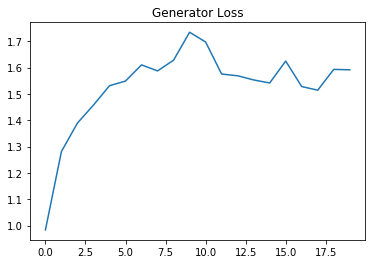

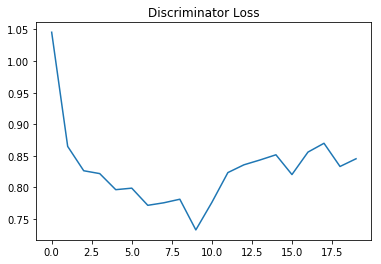

In [0]:
import matplotlib.pyplot as plt

generator_losses = np.load('./cGAN/generator_losses.npy')
plt.plot(list(range(0,generator_losses.shape[0])), generator_losses)
plt.title('Generator Loss')
plt.show()

import matplotlib.pyplot as plt
discriminator_losses = np.load('./cGAN/discriminator_losses.npy')
plt.plot(list(range(0,discriminator_losses.shape[0])), discriminator_losses)
plt.title('Discriminator Loss')
plt.show()